In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.MLP import MLP

In [2]:
hidden_dim = 32
layers = 3
output_dim = 1
learning_rate = 0.00005
num_epochs = 2000
epochs_step = 10
batch_size = 32
test_size=0.3
dropout_rate = 0.5
pos_weight_ratio = 10
ds_name = 'datasets/20220328-or-eng-shrink-full.csv'
train = True

In [3]:
data = pd.read_csv(ds_name)

# removed_cols = ['Postoperative Olanzapine', 'Postoperative Fluphenazine', 'Postoperative Flupentixol']
# data = data.drop(removed_cols, axis=1)

# 将特征和目标分开
features = data.drop('Label', axis=1).values
target = data['Label'].values

print(features.shape)
print(target.shape)

(1809, 59)
(1809,)


In [4]:
# 划分训练集和测试集
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=test_size, random_state=42)

ValueError: test_size=0.0 should be either positive and smaller than the number of samples 1809 or a float in the (0, 1) range

In [ ]:
# 将数据转换为PyTorch张量
train_features = torch.Tensor(train_features)
test_features = torch.Tensor(test_features)
train_target = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_target = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = train_features.shape[1]

In [ ]:
# Random seed
torch.manual_seed(42)

model = MLP(input_dim, hidden_dim, output_dim,
            layers=layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_weight = torch.tensor(
    (train_target == 0).sum() / (train_target == 1).sum(), dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*pos_weight_ratio)
unratio_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# To device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

model = model.to(device)
criterion = criterion.to(device)
unratio_criterion = unratio_criterion.to(device)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)

# Compile model
model = torch.compile(model)

/tmp/ipykernel_342001/2821676749.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(


tensor(24.3200)


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=100):
    train_losses = []
    test_losses = []
    sensitivities = []
    sppecificities = []
    best_model = None
    best_test_loss = 1000
    for epoch in tqdm(range(num_epochs)):
        model.train()

        if epoch == num_epochs // 2:
            criterion = nn.BCEWithLogitsLoss(
                pos_weight=pos_weight*pos_weight_ratio)
            criterion = criterion.to(device)

        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # To device
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # save model
        if (epoch + 1) % epochs_step == 0:
            # test
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            outputs = model(test_features)
            test_loss = unratio_criterion(outputs, test_target)
            test_losses.append(test_loss.item())

            outputs = outputs > 0.5

            sensitivity = torch.sum(outputs[test_target == 1] == 1).item(
            ) / torch.sum(test_target == 1).item()
            sensitivities.append(sensitivity)

            sppecificity = torch.sum(outputs[test_target == 0] == 0).item(
            ) / torch.sum(test_target == 0).item()
            sppecificities.append(sppecificity)

            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = model

            # torch.save(model.state_dict(),
            #            'pths/MLP-epoch-{}-acc-{:.4f}-sens-{:.4f}.pth'.format(epoch+1, acc*100, sensitivity*100))
    
            if (epoch + 1) % (epochs_step*10)== 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Sensitivity: {:.4f}, Specificity: {:.4f}'
                    .format(epoch + 1, num_epochs, train_loss, test_loss.item(), sensitivity, sppecificity))
    
    return train_losses, test_losses, sensitivities, sppecificities, best_model, best_test_loss

Number of positive samples: 50
Number of negative samples: 1216


  5%|▌         | 101/2000 [00:08<02:26, 12.96it/s]

Epoch [100/2000], Loss: 3.5676, Test Loss: 1.9324, Sensitivity: 1.0000, Specificity: 0.0000


 10%|█         | 201/2000 [00:17<02:46, 10.77it/s]

Epoch [200/2000], Loss: 3.4707, Test Loss: 1.9826, Sensitivity: 1.0000, Specificity: 0.0000


 15%|█▌        | 301/2000 [00:25<02:26, 11.60it/s]

Epoch [300/2000], Loss: 3.1951, Test Loss: 1.9500, Sensitivity: 1.0000, Specificity: 0.0000


 20%|██        | 401/2000 [00:33<02:30, 10.59it/s]

Epoch [400/2000], Loss: 3.0674, Test Loss: 1.9363, Sensitivity: 1.0000, Specificity: 0.0000


 25%|██▌       | 502/2000 [00:43<02:06, 11.85it/s]

Epoch [500/2000], Loss: 2.7333, Test Loss: 1.9214, Sensitivity: 1.0000, Specificity: 0.0000


 30%|███       | 602/2000 [00:51<01:59, 11.72it/s]

Epoch [600/2000], Loss: 2.8394, Test Loss: 1.9265, Sensitivity: 1.0000, Specificity: 0.0000


 35%|███▌      | 702/2000 [01:00<01:46, 12.22it/s]

Epoch [700/2000], Loss: 2.7247, Test Loss: 1.8738, Sensitivity: 1.0000, Specificity: 0.0190


 40%|████      | 802/2000 [01:08<01:48, 11.07it/s]

Epoch [800/2000], Loss: 2.5224, Test Loss: 1.7528, Sensitivity: 0.9444, Specificity: 0.2076


 45%|████▌     | 902/2000 [01:18<01:38, 11.09it/s]

Epoch [900/2000], Loss: 2.2491, Test Loss: 1.6432, Sensitivity: 0.9444, Specificity: 0.4019


 50%|█████     | 1002/2000 [01:26<01:22, 12.10it/s]

Epoch [1000/2000], Loss: 2.1442, Test Loss: 1.5377, Sensitivity: 0.9444, Specificity: 0.4933


 55%|█████▌    | 1102/2000 [01:34<01:14, 11.99it/s]

Epoch [1100/2000], Loss: 2.2394, Test Loss: 1.3752, Sensitivity: 0.8889, Specificity: 0.5867


 60%|██████    | 1202/2000 [01:43<01:08, 11.66it/s]

Epoch [1200/2000], Loss: 2.1357, Test Loss: 1.2853, Sensitivity: 0.8889, Specificity: 0.6362


 65%|██████▌   | 1302/2000 [01:52<01:00, 11.57it/s]

Epoch [1300/2000], Loss: 1.7863, Test Loss: 1.1936, Sensitivity: 0.8333, Specificity: 0.6971


 70%|███████   | 1402/2000 [02:01<00:48, 12.23it/s]

Epoch [1400/2000], Loss: 1.9189, Test Loss: 1.1765, Sensitivity: 0.7778, Specificity: 0.7200


 75%|███████▌  | 1502/2000 [02:09<00:44, 11.29it/s]

Epoch [1500/2000], Loss: 1.7853, Test Loss: 1.1478, Sensitivity: 0.7778, Specificity: 0.7505


 80%|████████  | 1602/2000 [02:17<00:29, 13.35it/s]

Epoch [1600/2000], Loss: 1.6994, Test Loss: 1.1296, Sensitivity: 0.7222, Specificity: 0.7771


 85%|████████▌ | 1702/2000 [02:25<00:23, 12.87it/s]

Epoch [1700/2000], Loss: 1.6486, Test Loss: 1.1491, Sensitivity: 0.6667, Specificity: 0.7962


 90%|█████████ | 1802/2000 [02:33<00:14, 13.57it/s]

Epoch [1800/2000], Loss: 1.5902, Test Loss: 1.1893, Sensitivity: 0.6667, Specificity: 0.8152


 95%|█████████▌| 1902/2000 [02:41<00:08, 12.13it/s]

Epoch [1900/2000], Loss: 1.7358, Test Loss: 1.2594, Sensitivity: 0.6667, Specificity: 0.8229


100%|██████████| 2000/2000 [02:49<00:00, 11.77it/s]


Epoch [2000/2000], Loss: 1.5606, Test Loss: 1.3131, Sensitivity: 0.5556, Specificity: 0.8286


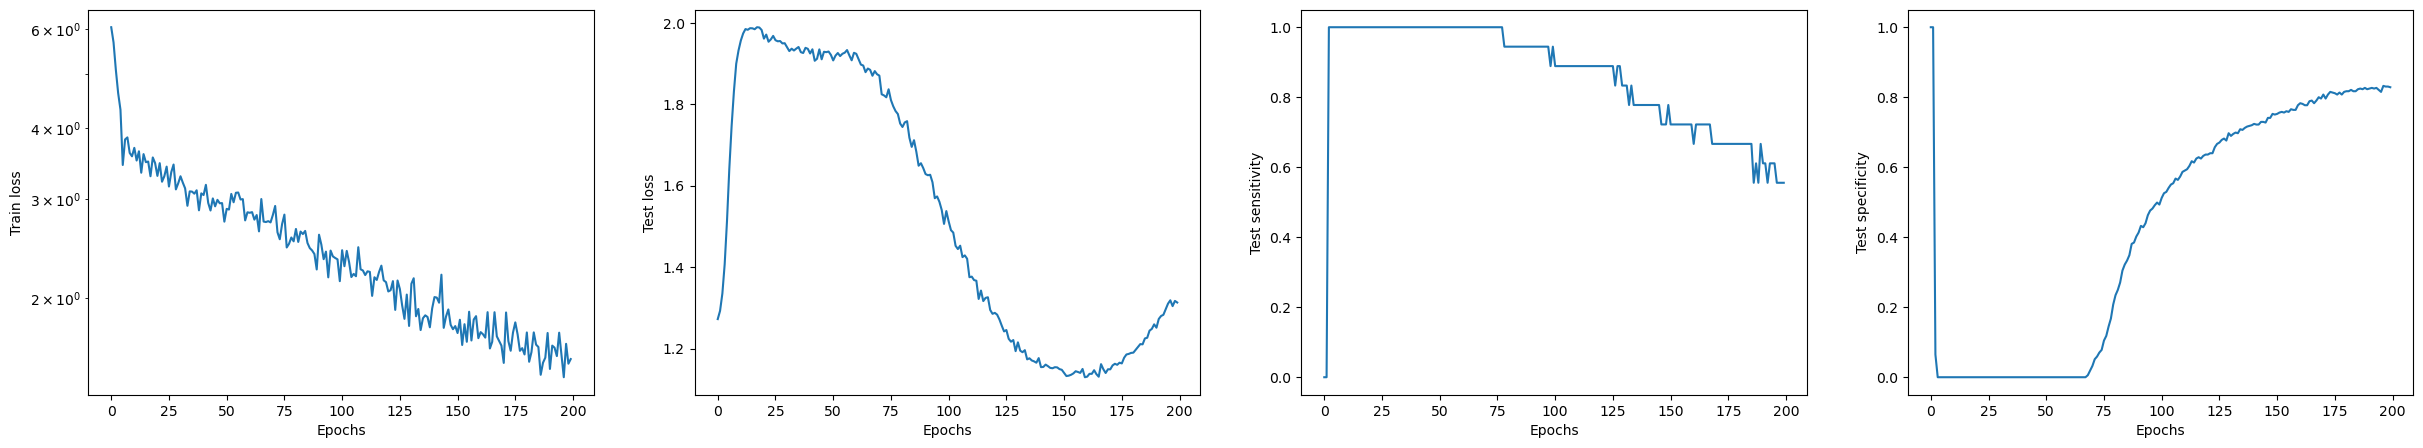

In [ ]:
if train == True:
    # torch._dynamo.config.suppress_errors = True

    # Count number of positive and negative samples
    print('Number of positive samples: {}'.format((train_target == 1).sum()))
    print('Number of negative samples: {}'.format((train_target == 0).sum()))

    train_losses, test_losses, sensitivities, sppecificities, model, best_test_loss = train_model(
        model, criterion, optimizer, num_epochs=num_epochs)

    # Plot losses and accuracies separately
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Train loss')
    ax[0].set_yscale('log')
    ax[1].plot(test_losses)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test loss')
    ax[2].plot(sensitivities)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Test sensitivity')
    ax[3].plot(sppecificities)
    ax[3].set_xlabel('Epochs')
    ax[3].set_ylabel('Test specificity')
    
    plt.savefig('outputs/MLP-{:04}-{:02.4f}.png'.format(num_epochs, test_losses[-1]*100))
    plt.show()

    torch.save(model.state_dict(), 'pths/MLP-epoch-{}-acc-{:.4f}.pth'.format(num_epochs, best_test_loss*100))

In [ ]:
def test_model(model, features, target):
    # Test in all data
    model.eval()
    outputs = model(features)
    outputs = outputs > 0.5

    # Reshape
    outputs = outputs.view(-1)
    target = target.view(-1)
    success = torch.sum(outputs == target).item()
    print('Success: {}/{}'.format(success, len(target)))

    acc = success / len(target)
    print('Accuracy: {:.2f}'.format(acc))

    # Confusion matrix
    TP = torch.sum((outputs == 1) & (target == 1)).item()
    TN = torch.sum((outputs == 0) & (target == 0)).item()
    FP = torch.sum((outputs == 1) & (target == 0)).item()
    FN = torch.sum((outputs == 0) & (target == 1)).item()

    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(TP, TN, FP, FN))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print('Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))

In [ ]:
# Load model
# model.load_state_dict(torch.load('pths/MLP-500-9.5580e-01.pth'))

print('In test set:')
test_model(model, test_features, test_target)

print('\nIn all data:')
test_model(model, torch.Tensor(features).to(device), torch.Tensor(target).to(device))

In test set:
Success: 445/543
Accuracy: 0.82
TP: 10, TN: 435, FP: 90, FN: 8
Sensitivity: 0.56, Specificity: 0.83

In all data:
Success: 1509/1809
Accuracy: 0.83
TP: 60, TN: 1449, FP: 292, FN: 8
Sensitivity: 0.88, Specificity: 0.83
